# Case study of uniaxial compression tests

This is an example of how to use Paramaterial to process a dataset of uniaxial compression test measurements.
The data should be formatted as a set of csv files containing measurements for each test, and a single excel spreadsheet containing the metadata for the dataset.
There should be a single row in the excel spreadsheet for each csv file.

The analysis takes 4 stages:
- Data preparation
- Data processing
- Model fitting
- Test report generation

In [50]:
import numpy as np
%matplotlib inline

In [51]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

import paramaterial as pam
from paramaterial.plug import DataSet, DataItem

## Data preparation


### Backup data and raw data
1. Create two directories: "data", "info".
2. Save all csv files into a directory called "data/00 backup data".
3. Generate a corresponding info table "info/00 backup info.xlsx" using make_info_table function. The function writes the table to a spreadsheet and returns it as a dataframe.
5. Fill in the info and save backup info and data.
6. Copy to raw info and data.

In [52]:
backup_info = pam.preparing.make_info_table('data/00 backup data', columns=['temperature', 'rate', 'material'])
backup_info.to_excel('info/00 backup info unfilled.xlsx')
backup_info.head()

,test id,old filename,temperature,rate,material
0,NaN,testID_0080.csv,NaN,NaN,NaN
1,NaN,testID_0081.csv,NaN,NaN,NaN
2,NaN,testID_0082.csv,NaN,NaN,NaN
3,NaN,testID_0083.csv,NaN,NaN,NaN
4,NaN,testID_0084.csv,NaN,NaN,NaN


Add the metadata into the excel spreadsheet.
Apply a naming convention in the "test id" column.

In [53]:
backup_info = pd.read_excel('info/00 backup info.xlsx')
backup_info.head()

,test id,old filename,test type,material,temperature,rate,L_0,D_0
0,baron_test_001,testID_0080.csv,UC,AC,300,100,15,10
1,baron_test_002,testID_0081.csv,UC,AC,300,100,15,10
2,baron_test_003,testID_0082.csv,UC,AC,330,100,15,10
3,baron_test_004,testID_0083.csv,UC,AC,330,100,15,10
4,baron_test_005,testID_0084.csv,UC,AC,360,100,15,10


Copy backup data and info into raw data and info, then leave backup alone in all further steps.

In [54]:
pam.preparing.copy_data_and_info(old_data_dir='data/00 backup data', new_data_dir='data/01 prepared data',
                                 old_info_path='info/00 backup info.xlsx', new_info_path='info/01 prepared info.xlsx')

Copied 167 files from data/00 backup data to data/01 prepared data.
Copied info table from info/00 backup info.xlsx to info/01 prepared info.xlsx.


### Prepared data

Rename files according to test id.

In [55]:
# pam.preparing.rename_by_test_id('data/01 prepared data', 'info/01 prepared info.xlsx')

Check that column headers of data files are all the same. If not the same, fix.

In [56]:
pam.preparing.check_column_headers('data/01 prepared data')

Checking column headers...
First file headers:
	['Time(sec)', 'Force(kN)', 'Jaw(mm)', 'PowAngle(deg)', 'Power(W)', 'Pram', 'PTemp', 'Strain', 'Stress(MPa)', 'Stroke(mm)', 'TC1(C)', 'wedge(mm)']
Headers in all files are the same as in the first file.


In [57]:
raw_dataset = DataSet('data/01 prepared data', 'info/01 prepared info.xlsx')

### Dataitem EDA
Look at one dataitem. Notice the use of the square brackets to get a subset, then to get a slice, then to get a single item.

In [58]:
# dataitem = raw_dataset[{'rate': [1], 'material': ['H560']}][0:2][0]
dataitem = raw_dataset[{'rate': [1], 'material': ['H560']}][0:2][1]
# dataitem = raw_dataset[{'rate': [1], 'material': ['H560']}][0:2][2]

dataitem.data.head()

,Time(sec),Force(kN),Jaw(mm),PowAngle(deg),Power(W),Pram,PTemp,Strain,Stress(MPa),Stroke(mm),TC1(C),wedge(mm)
0,0.0,0.909049,0.216324,0.0,0,10.594783,0.001361,0.014535,11.410231,10.595052,26.745852,-9.106068
1,0.1,0.899632,0.004254,0.0,0,10.594783,0.219613,0.000278,11.439822,10.595037,26.730957,-9.453249
2,0.2,0.888387,-0.006342,0.0,0,10.594783,0.516075,-0.000412,11.315112,10.595076,26.721537,-9.473638
3,0.3,0.886075,-0.006448,0.0,0,10.594783,0.815921,-0.000454,11.273579,10.595632,26.755287,-9.475232
4,0.4,0.876320,-0.006328,0.0,0,10.594783,1.115915,-0.000415,11.147420,10.595306,26.735609,-9.475446


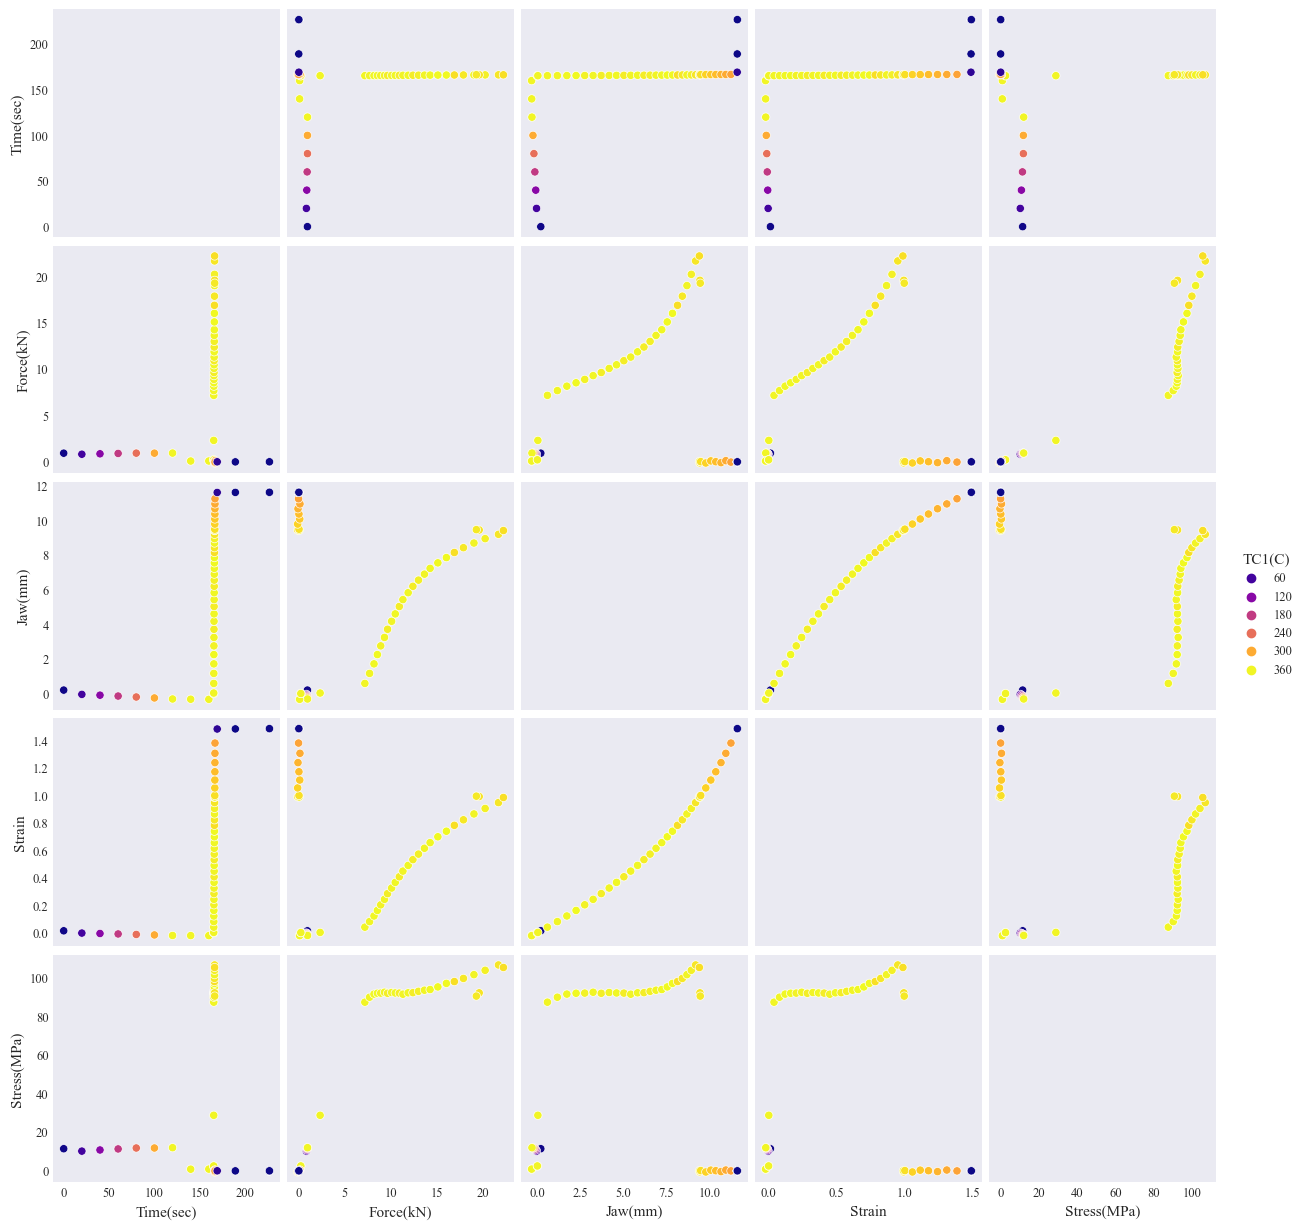

In [59]:
dataitem.data = dataitem.data.drop(columns=['PowAngle(deg)', 'Power(W)', 'Pram', 'Stroke(mm)', 'wedge(mm)', 'PTemp'])
sns.pairplot(pd.concat([dataitem.data.iloc[:-199:200], dataitem.data.iloc[-10:]]), hue='TC1(C)', palette='plasma')

### Dataset EDA

In [60]:
raw_info = raw_dataset.info_table
raw_info.head()

,test id,old filename,test type,material,temperature,rate,L_0,D_0
0,baron_test_001,testID_0080.csv,UC,AC,300,100,15,10
1,baron_test_002,testID_0081.csv,UC,AC,300,100,15,10
2,baron_test_003,testID_0082.csv,UC,AC,330,100,15,10
3,baron_test_004,testID_0083.csv,UC,AC,330,100,15,10
4,baron_test_005,testID_0084.csv,UC,AC,360,100,15,10


In [61]:
raw_info.nunique()

test id         167
old filename    167
test type         1
material          3
temperature       6
rate              4
L_0               1
D_0               1
dtype: int64

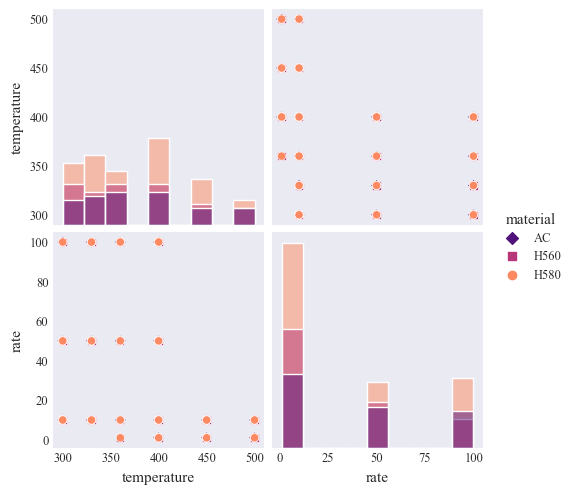

In [62]:
sns.pairplot(raw_info, vars=['temperature', 'rate'], hue='material', diag_kind='hist', markers=['D', 's', 'o'],
             palette='magma')

In [63]:
data_matrix = raw_info[['material', 'temperature', 'rate']].value_counts().sort_index()
data_matrix

material  temperature  rate
AC        300          10      2
                       50      2
                       100     2
          330          10      2
                       50      3
                       100     2
          360          10      2
                       50      3
                       100     3
          400          1       2
                       10      2
                       50      2
                       100     2
          450          1       2
                       10      2
          500          1       2
                       10      2
H560      300          10      6
                       50      2
                       100     2
          330          10      4
                       50      2
                       100     2
          360          1       2
                       10      4
                       50      2
                       100     2
          400          1       2
                       10      2
               

Make the experimental matrix.

In [64]:
data_matrix = data_matrix.to_frame().reset_index()
data_matrix.columns = ['material', 'temperature', 'rate', 'count']
data_matrix.pivot_table(index=['material', 'rate'], columns='temperature', values='count').fillna(0).astype(int)

temperature    300  330  360  400  450  500
material rate                              
AC       1       0    0    0    2    2    2
         10      2    2    2    2    2    2
         50      2    3    3    2    0    0
         100     2    2    3    2    0    0
H560     1       0    0    2    2    3    2
         10      6    4    4    2    2    2
         50      2    2    2    5    0    0
         100     2    2    2    1    0    0
H580     1       0    0    1    5    4    2
         10      9    7    4    7    7    4
         50      4    5    3    4    0    0
         100     2    5    5    5    0    0

Plot the dataset.

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>)

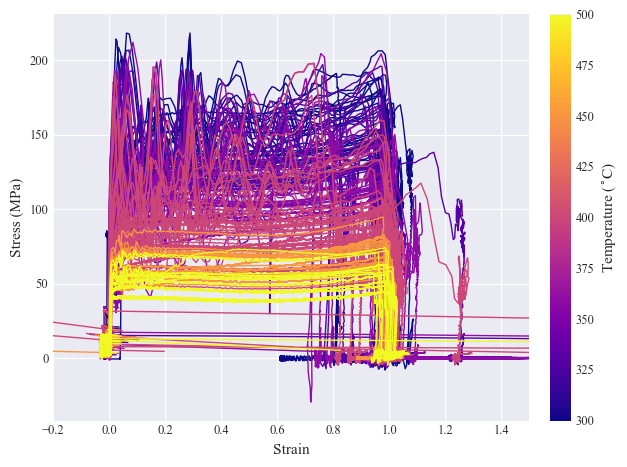

In [65]:
# configure dataset plot
ds_plot = lambda dataset: pam.plotting.dataset_plot(dataset, x='Strain', y='Stress(MPa)', ylabel='Stress (MPa)',
                                                    cbar_by='temperature', cbar_label='Temperature ($^{\circ}$C)',
                                                    xlim=(-0.2, 1.5), grid=True)
ds_plot(raw_dataset)

(<Figure size 1200x800 with 13 Axes>,
 array([[<AxesSubplot:title={'center':'1 s$^{-1}$'}, xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:title={'center':'10 s$^{-1}$'}, xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:title={'center':'50 s$^{-1}$'}, xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:title={'center':'100 s$^{-1}$'}, xlabel='Strain', ylabel='Stress (MPa)'>],
        [<AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>],
        [<AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>]],
       dtype=object))

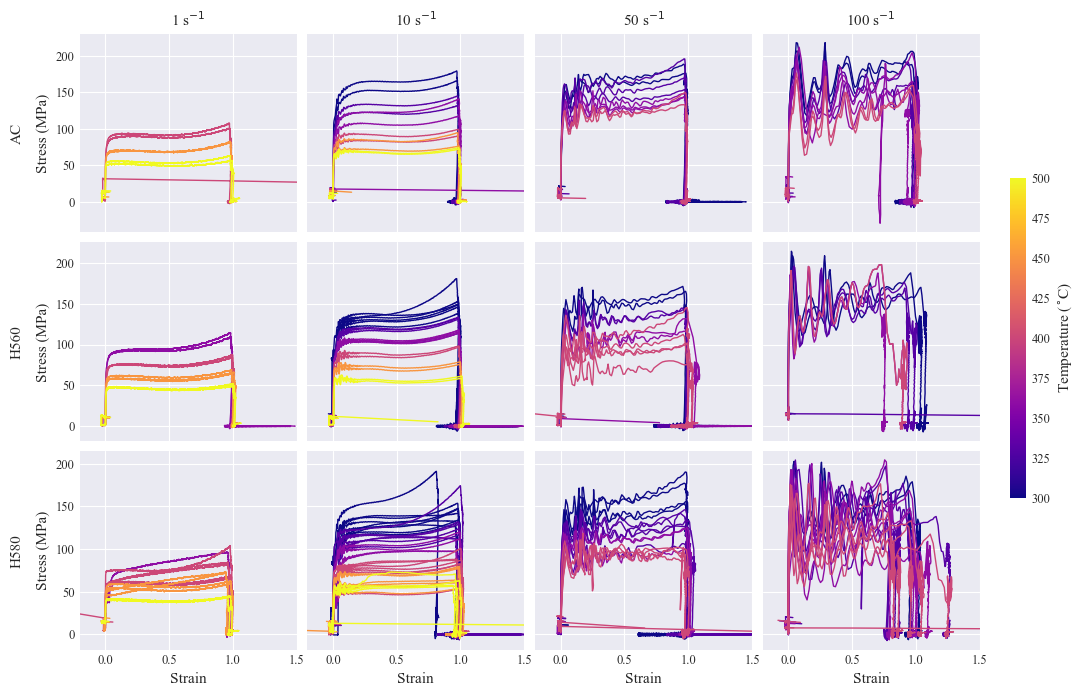

In [66]:
# configure dataset subplot
ds_subplot = lambda dataset: pam.plotting.dataset_subplots(
    dataset, x='Strain', y='Stress(MPa)', ylabel='Stress (MPa)',
    nrows=3, ncols=4,
    rows_by='material', cols_by='rate',
    row_keys=[['AC'], ['H560'], ['H580']],
    col_keys=[[1], [10], [50], [100]],
    row_titles=['AC', 'H560', 'H580'],
    col_titles=['1 s$^{-1}$', '10 s$^{-1}$', '50 s$^{-1}$', '100 s$^{-1}$'],
    cbar_by='temperature', cbar_label='Temperature ($^{\circ}$C)',
    xlim=(-0.2, 1.5), grid=True, wspace=0.05, hspace=0.05
)

ds_subplot(raw_dataset)

## Processing
We now want to:
- Trim the data
- Apply friction corrections

### Trimming the trailing data
We can identify the end of the compression test by the maximum force. For example:

<AxesSubplot:xlabel='Strain'>

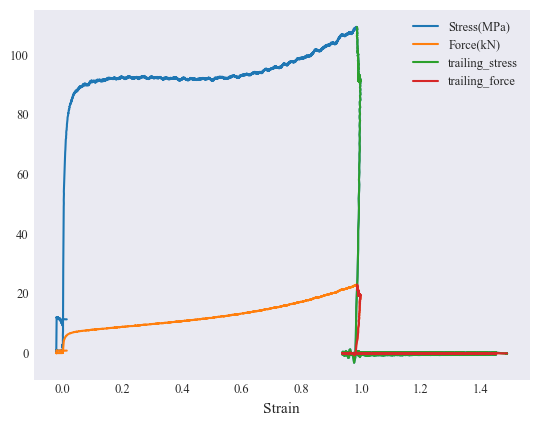

In [67]:
ax = dataitem.data.plot(x='Strain', y=['Stress(MPa)', 'Force(kN)'])
max_force_index = dataitem.data['Force(kN)'].idxmax()
trailing_data = dataitem.data.iloc[max_force_index:].copy()
trailing_data[['trailing_stress', 'trailing_force']] = trailing_data[['Stress(MPa)', 'Force(kN)']]
trailing_data['trailing_force'] = trailing_data['Force(kN)']
trailing_data.plot(ax=ax, x='Strain', y=['trailing_stress', 'trailing_force'])

<AxesSubplot:xlabel='Strain'>

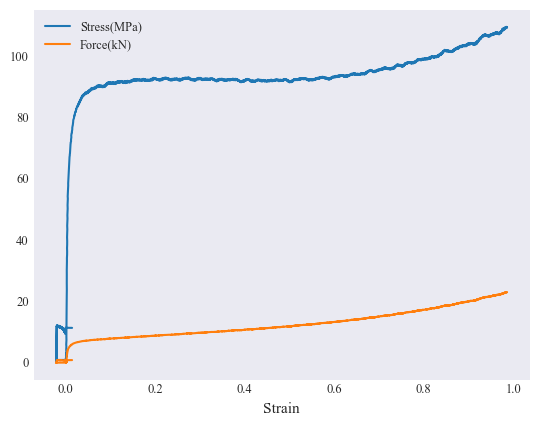

In [68]:
def remove_trailing_data(dataitem: DataItem):
    max_force = dataitem.data['Force(kN)'].max()
    max_force_index = dataitem.data[dataitem.data['Force(kN)'] == max_force].index[0]
    dataitem.data = dataitem.data[:max_force_index]
    return dataitem


remove_trailing_data(dataitem).data.plot(x='Strain', y=['Stress(MPa)', 'Force(kN)'])

Then, we apply the processing function to the entire dataset.

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>)

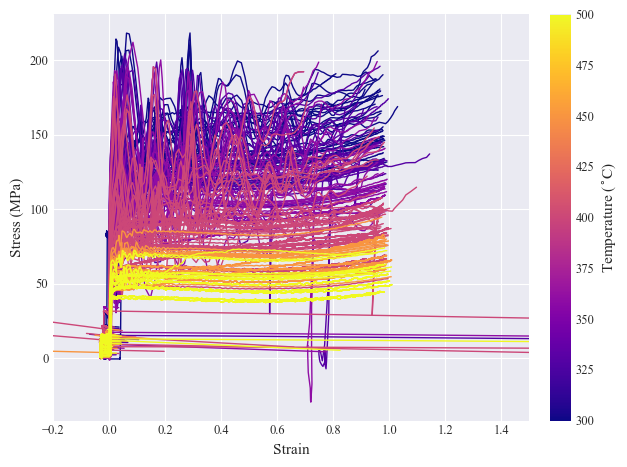

In [69]:
trimmed_dataset = raw_dataset.apply(remove_trailing_data)
ds_plot(trimmed_dataset)

In [70]:
# ds_subplot(trimmed_dataset)

### Trimming the leading data
- Use the derivative of displacement to identify when hit happens
- Trim data before hit.

In [78]:
djaw_dt = np.deriv
data

NameError: name 'data' is not defined

### Applying the friction correction.
$$
\sigma = P \left[\frac{h}{\mu d} \right]^{-2}\left[\exp\left(\frac{\mu d}{h}\right) - \frac{\mu d}{h} - 1 \right]^{-1}
$$

In [ ]:
di = dataitem

h_0 = di.info['L_0(mm)'] # initial height in axial direction
d_0 = di.info['D_0 (mm)']  # initial diameter

h = h_0 - di.data['Jaw(mm)']  # instantaneous height
d = d_0*np.sqrt(h_0/h)  # instantaneous diameter
P = di.data['Force(kN)']*1000*4/(np.pi*d**2)  # pressure (MPa)
mu = 0.3  # friction coefficient

di.data['Corrected Stress (MPa)']  = P/(1+(mu*d)/(3*h))
di.data.plot(x='Strain(MPa)')

### Making representative curves


### Screening

## Modelling
1. Identify points of interest algorithmically
2. Fit material model